In [1]:
import geopandas as gpd
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon,Point
import jenkspy

In [2]:
nanshan_gdf = gpd.read_file('./data/nanshan_grid.shp')
reward = pd.read_excel('./data/reward.xlsx')
nanshan_reward = pd.merge(reward, nanshan_gdf, on='fnid')

In [3]:
nanshan_reward = gpd.GeoDataFrame(nanshan_reward, geometry='geometry')

In [4]:
trajectory_df = gpd.read_file('./data/nanshan_traj.shp').to_crs(epsg=4326)
n_sample = 100 # the number you need
trajectory_sample = trajectory_df.iloc[:n_sample]

In [5]:
nanshan_reward

,fnid,reward1-2,reward1-1,reward1-0,reward0-2,reward0-1,reward0-0,county_cod,county_nam,geometry
0,4704,0.496767,0.504167,0.497126,0.497305,0.504169,0.496946,440305.0,南山区,"POLYGON ((113.90534 22.47621, 113.90290 22.476..."
1,9700,0.335129,0.472549,0.335488,0.335609,0.472781,0.335609,440305.0,南山区,"POLYGON ((113.90046 22.50723, 113.89802 22.507..."
2,14003,0.553879,0.576961,0.554238,0.554078,0.576753,0.554078,440305.0,南山区,"POLYGON ((113.94439 22.53604, 113.94683 22.536..."
3,9357,0.636853,0.746078,0.636853,0.637082,0.745954,0.636723,440305.0,南山区,"POLYGON ((113.93463 22.50501, 113.93218 22.505..."
4,14000,0.572917,0.646569,0.572917,0.573123,0.646641,0.573482,440305.0,南山区,"POLYGON ((113.93951 22.53382, 113.93707 22.533..."
...,...,...,...,...,...,...,...,...,...,...
1454,17565,0.422773,0.400490,0.422773,0.422566,0.400687,0.422925,440305.0,南山区,"POLYGON ((113.92730 22.55598, 113.92486 22.555..."
1455,7210,0.533046,0.590686,0.533405,0.533597,0.591221,0.533238,440305.0,南山区,"POLYGON ((113.92242 22.49172, 113.91998 22.491..."
1456,13982,0.480603,0.425980,0.480963,0.480776,0.425944,0.480776,440305.0,南山区,"POLYGON ((113.89558 22.53382, 113.89314 22.533..."
1457,10403,0.602371,0.405392,0.602730,0.602946,0.405346,0.602587,440305.0,南山区,"POLYGON ((113.87362 22.51166, 113.87118 22.511..."


In [6]:
G = nx.Graph()
for index, row in nanshan_reward.iterrows():
    current_node = tuple(row['geometry'].exterior.coords)
    centroid = row['geometry'].centroid
    c = (centroid.x, centroid.y)
    fnid = row['fnid'] 
    r = row['reward1-1']
    G.add_node(current_node, fnid=fnid, reward=r, coord=c)

    for neighbor_index, neighbor_row in nanshan_reward.iterrows():
        if index == neighbor_index:  
            continue
        neighbor_node = tuple(neighbor_row['geometry'].exterior.coords)
        neighbor_r = neighbor_row['reward1-1']
        if Polygon(current_node).touches(Polygon(neighbor_node)):
            edge_reward = 1-(r + neighbor_r) / 2  # Edge reward is inversely related to node rewards to prioritize higher rewards
            G.add_edge(current_node, neighbor_node, weight=edge_reward, length = 0.1, composite = edge_reward + 0.1)

In [7]:
def nearest_node(graph, point):
    point_coords = (point.x, point.y)
    distances = {node: np.sqrt((graph.nodes[node]['coord'][0] - point_coords[0])**2 + 
                               (graph.nodes[node]['coord'][1] - point_coords[1])**2) 
                 for node in graph.nodes()}
    nearest_node = min(distances, key=distances.get)
    return nearest_node

In [8]:
def update_edge_weights(graph, flow):
    for edge in graph.edges:
        # base_weight = graph[edge[0]][edge[1]].get('weight', 1)
        new_weight = flow[edge]
        graph[edge[0]][edge[1]]['weight'] = new_weight

def calculate_composite_weight(edge_weight, length_weight=1.0):
    return edge_weight + length_weight

def traffic_assignment(graph, trajectory_df, convergence_threshold=0.01):
    flow = {edge: 1 for edge in graph.edges}
    converged = False
    iteration = 0
    max_iterations = 1000  # set max iterations
    previous_total_flow = None

    while not converged and iteration < max_iterations:
        # reset flow
        current_total_flow = 0

        for edge in flow:
            flow[edge] = graph[edge[0]][edge[1]].get('weight', 1)
        
        # distribute and update flow
        for index, row in trajectory_df.iterrows():
            start_point = Point(row['geometry'].coords[0])
            end_point = Point(row['geometry'].coords[-1])
            start_nearest = nearest_node(graph, start_point)
            end_nearest = nearest_node(graph, end_point)
            try:
                path = nx.shortest_path(graph, source=start_nearest, target=end_nearest, weight='composite')
            except nx.NetworkXNoPath:
                print("no path")
                continue
            for i in range(len(path) - 1):
                edge = (path[i], path[i+1])
                if edge in flow:
                    flow[edge] += 1
                elif (edge[1], edge[0]) in flow:  # Check the reverse direction for undirected graphs
                    flow[(edge[1], edge[0])] += 1
                current_total_flow += 1

        update_edge_weights(graph, flow)

        for _, _, data in graph.edges(data=True):
            length_weight = data['length']
            composite_weight = calculate_composite_weight(data['weight'], length_weight)
            data['composite'] = composite_weight

        if previous_total_flow is not None:
            flow_change = abs(current_total_flow - previous_total_flow) / previous_total_flow
            print(current_total_flow,previous_total_flow,flow_change)
            if flow_change < convergence_threshold:
                converged = True
                print("Converged!")
        
        previous_total_flow = current_total_flow
        iteration += 1
        print(iteration)

    return graph

In [9]:
G_weight = traffic_assignment(G, trajectory_sample, convergence_threshold=0.01)

1
758 734 0.0326975476839237
2
936 758 0.23482849604221637
3
1184 936 0.26495726495726496
4
1192 1184 0.006756756756756757
Converged!
5


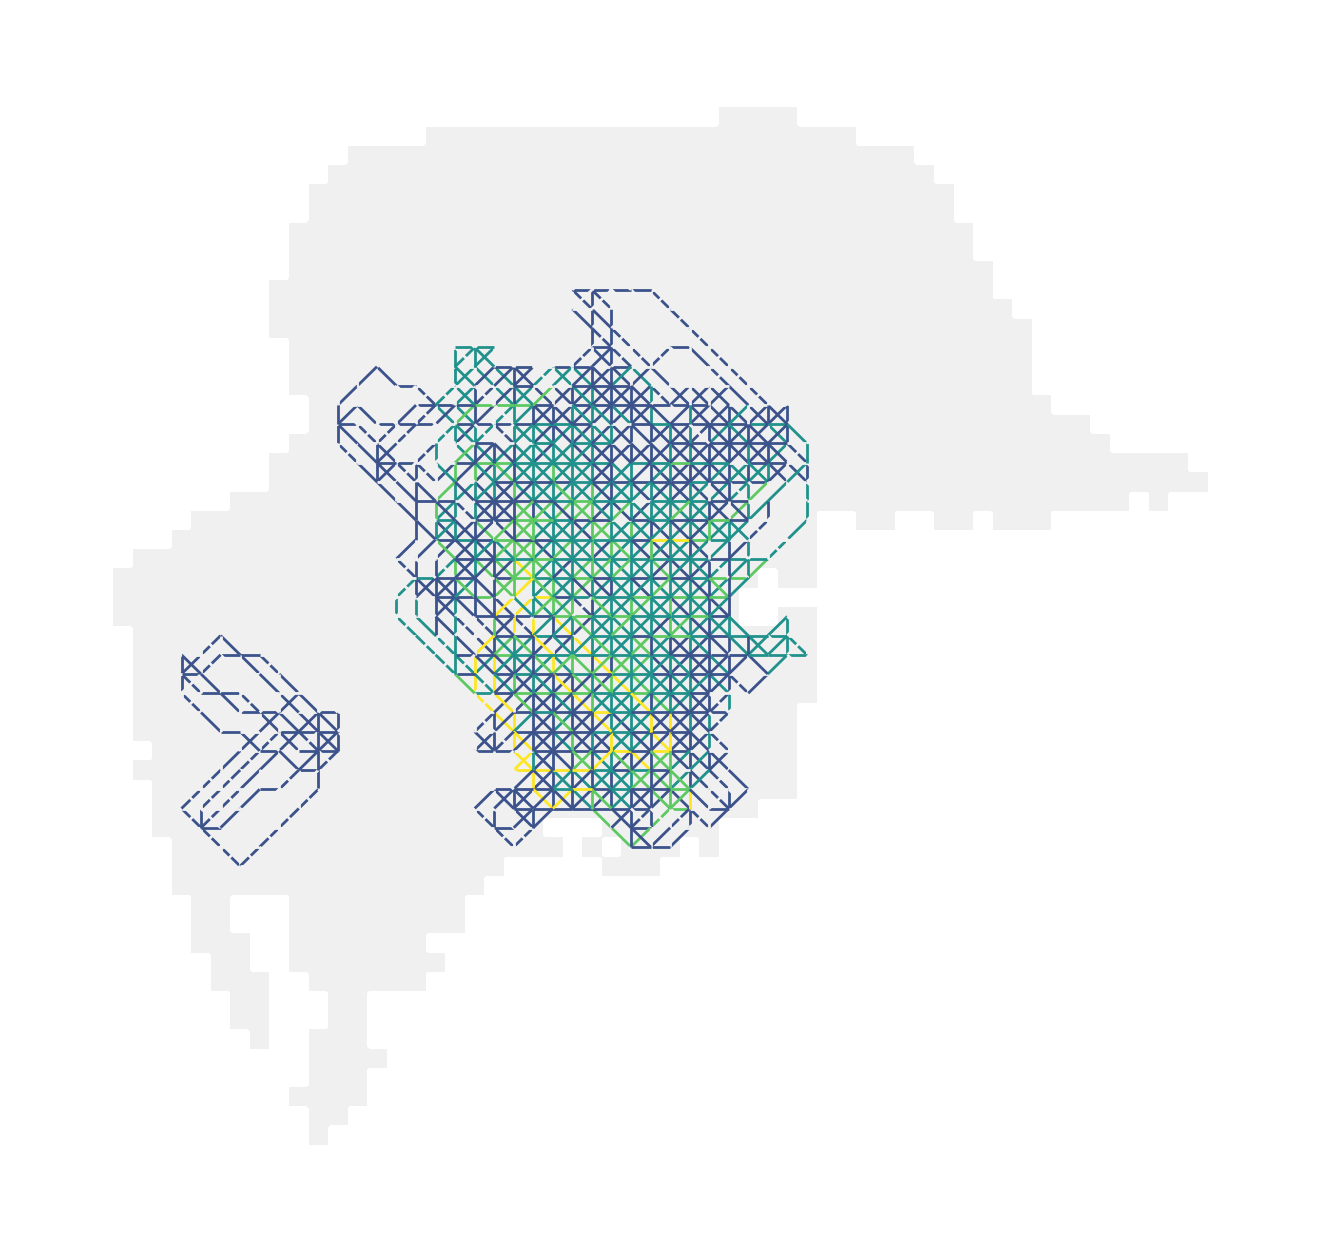

In [10]:
pos = {node: G.nodes[node]['coord'] for node in G.nodes()}

edges, weights = zip(*nx.get_edge_attributes(G_weight, 'weight').items())

fig, ax = plt.subplots(figsize=(20, 16))
nanshan_gdf.plot(ax=ax, color='#f0f0f0')
# trajectory_sample.plot(ax=ax, linewidth=2, color='red') 
# Extract edges with weight greater than 1 and their corresponding weights
edges_weight_gt_1 = [(u, v) for (u, v, w) in G_weight.edges(data=True) if w['weight']]
weights_gt_1 = [G_weight[u][v]['weight'] for u, v in edges_weight_gt_1] if edges_weight_gt_1 else []

# Use jenkspy to calculate natural breaks
num_buckets = 5
breaks = jenkspy.jenks_breaks(weights_gt_1, n_classes=num_buckets)

# Assign colors for each bin
bucket_indices = np.searchsorted(breaks, weights_gt_1, side='right') - 1
bucket_indices = np.clip(bucket_indices, 0, num_buckets-1)  # 确保索引在正确的范围内

# Assign colors for each bin
colors = [plt.cm.viridis(i / (num_buckets-1)) for i in bucket_indices]
# colors = [plt.cm.coolwarm(i / (num_buckets-1)) for i in bucket_indices]

colors = ['#f0f0f0' if i < 1 else plt.cm.viridis(i / (num_buckets-1)) for i in bucket_indices]

# Draw edges with weight greater than 1 using the assigned colors
if edges_weight_gt_1:
    nx.draw_networkx_edges(G_weight, pos,ax=ax, edgelist=edges_weight_gt_1, edge_color=colors, width=2)

# Display the figure
plt.axis('off')
plt.savefig('./img/grid_dta.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
G_update = G.copy()

for node in G_update.nodes:
    edge_weights = [G_update[node][neighbor]['weight'] for neighbor in G_update.neighbors(node)]
    
    if edge_weights:  
        average_weight = sum(edge_weights) / len(edge_weights)
    else:
        average_weight = 0 
    
    G_update.nodes[node]['updated_reward'] = average_weight 

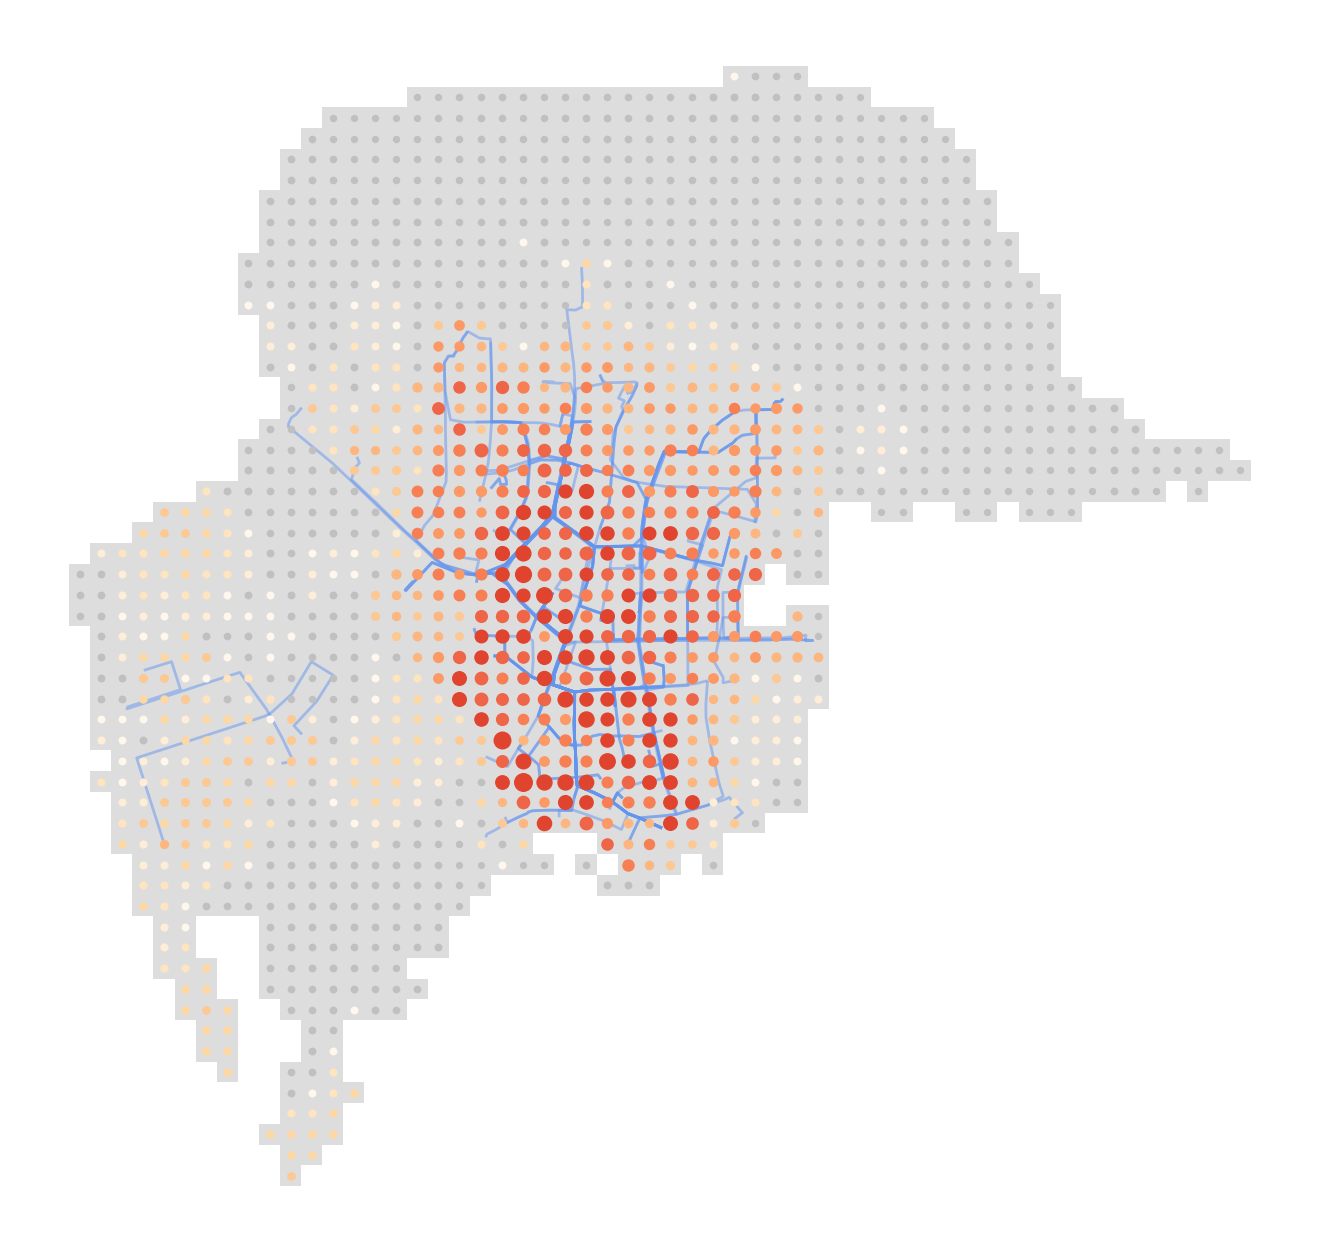

In [33]:
pos = {node: G_update.nodes[node]['coord'] for node in G_update.nodes()}

node_rewards = np.array([G_update.nodes[node]['updated_reward'] for node in G_update.nodes()])

num_buckets = 20
breaks = np.quantile(node_rewards, np.linspace(0, 1, num_buckets+1))

bucket_indices = np.searchsorted(breaks, node_rewards, side='right') - 1
bucket_indices = np.clip(bucket_indices, 0, num_buckets-1) 

# colors = [plt.cm.viridis(i / (num_buckets-1)) for i in bucket_indices]
colors = ['silver' if i < 10 else plt.cm.OrRd((i - 10) / (num_buckets - 11)* 0.7) for i in bucket_indices]

fig, ax = plt.subplots(figsize=(20, 16))

nanshan_gdf.plot(ax=ax, color='#dddddd')
trajectory_sample.plot(ax=ax, linewidth=2, color='#6495ED',alpha=0.5) 

min_size = 15
max_size = 160
normalized_rewards = (node_rewards - node_rewards.min()) / (node_rewards.max() - node_rewards.min())
node_sizes = [min_size + (max_size - min_size) * reward for reward in normalized_rewards]

for (node, _), color, size in zip(G_update.nodes(data='updated_reward'), colors, node_sizes):
    nx.draw_networkx_nodes(G_update, pos, nodelist=[node], node_color=[color], node_size=size, ax=ax)

# edges, weights = zip(*nx.get_edge_attributes(G_update, 'weight').items())
# nx.draw_networkx_edges(G_update, pos, ax=ax, edge_color="#aaaaaa", width=1)

plt.axis('off')
plt.savefig('./img/grid_dta_with_nodes.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
nanshan_gdf['updated_reward'] = 0

for node, data in G_update.nodes(data=True):
    fnid = data['fnid']  
    reward = data['updated_reward'] 
    nanshan_gdf.loc[nanshan_gdf['fnid'] == fnid, 'updated_reward'] = reward

C:\Users\liboy\AppData\Local\Temp\ipykernel_20136\3501176559.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.4474466666666667' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  nanshan_gdf.loc[nanshan_gdf['fnid'] == fnid, 'updated_reward'] = reward


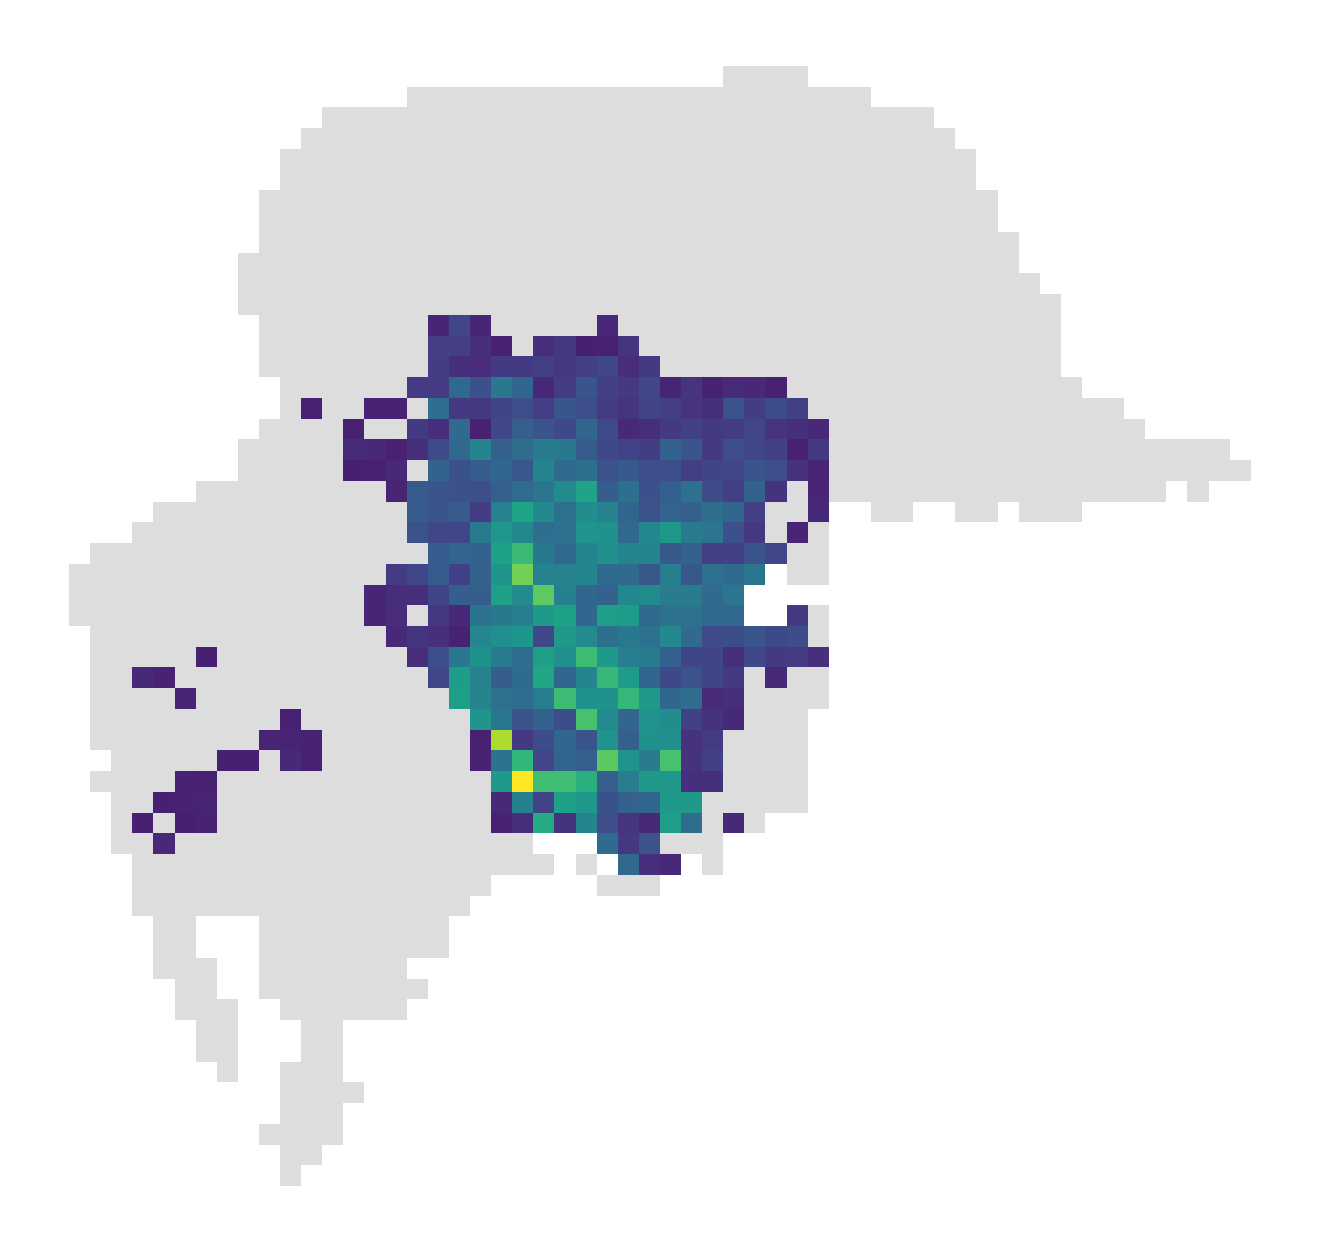

In [14]:
import matplotlib.pyplot as plt
import matplotlib.colors

nanshan_gdf['color'] = ['#dddddd' if reward < 1 else plt.cm.viridis((reward - nanshan_gdf['updated_reward'].min()) / (nanshan_gdf['updated_reward'].max() - nanshan_gdf['updated_reward'].min())) for reward in nanshan_gdf['updated_reward']]

# 绘图
fig, ax = plt.subplots(figsize=(20, 16))
nanshan_gdf.plot(ax=ax, color=nanshan_gdf['color'], legend=True)

ax.set_axis_off()
plt.show()
